# Categorical Deep Q-Learning (C-51)
---

In this algorithm we use a neural network that, instead of estimating the expected state-action value, estimates it's distribution. This network returns the `atom_size` bin histogram with state-action value distribution for each action. We denote the network as $P$ and the distribution as $Z(s, a)$. This implies couple of changes in the algorithm.
1) Greedy action is selected as
$$a = \argmax\limits_{a}\sum_{i}P(Z(s, a)=z_i)z_i$$
In the code the sums of the distributions are returned by forward propagation whereas the distribution can be accessed by `network.dist(state)`

2) The learning process looks as follows:
- Sample ($state, action, reward, next_state, done$) from the Replay Buffer
- For each atom $i' \in {0, 1, ..., N}$
    - Calculate $\tau z_{i'} \leftarrow [r + \gamma z_{i'}]_{z_{min}}^{z_{max}}$
    - As this distribution is squeezed (by gamma) and shifted (by reward), interpolate them to the grid point:
        - compute lower and upper indexes to know where to cast each histogram bin:
            $$b \leftarrow (\tau z_{i'} - z_{min}) / \Delta z$$
            $$l \leftarrow \lfloor b \rfloor $$
            $$u \leftarrow \lceil b \rceil $$
        - Distribute probabilities
            $$p_l \leftarrow p_l + P_{w^-}(Z(s', a')=z_{i'})(u - b)$$
            $$p_u \leftarrow p_u + P_{w^-}(Z(s', a')=z_{i'})(i - l)$$
- Calculate the entropy loss:
    $$L(w) \leftarrow -\sum_i p_i \log P_w(Z(s, a) = z_i)$$
- Update weights:
    $$w \leftarrow w - \alpha \nabla_w L(w)$$


A very good lecture that helped me to understand this process is available [here](https://www.youtube.com/watch?v=r-Yk6-jagDU).

Additionally, interpolating $\tau z_{i'}$ is a challenging piece of code, if you want to make it tensor-based and computationally effective. I based on the code from [Curt Park](https://github.com/Curt-Park/rainbow-is-all-you-need/blob/master/06.categorical_dqn.ipynb) repositiory, which is also a very good resource to study the rainbow algorithm.

In [1]:
# Import packages
import gym
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Device:', device)

Device: cuda:0


In [2]:
env = gym.make(config.ENVIRONMENT)

In [3]:
from rainbow.categorical_agent import Agent

agent = Agent(
    state_size=env.observation_space.shape[0], 
    action_size=env.action_space.n,
    buffer_size = int(1e5),
    batch_size = 64,
    gamma = 0.99,
    lr = 5e-4,
    update_every = 4, # How often to update the network
    device=device,
    # PER parameters
    per_alpha = 0.2,
    per_beta_start = 0.4,
    per_beta_frames = 1e5,
    per_prior_eps = 1e-6, 
    # Dueling parameters
    clip_grad=10, 
    #N-step parameters
    n_steps = 3, 
    # Distributional parameters
    atom_size=10, # Originally it was 51
    v_min=0,
    v_max=200,
    )



In [4]:
def train_agent(n_episodes=config.MAX_EPISODES, 
        max_t=config.MAX_TIMESTEPS, 
        eps_start=config.EPSILON_START, 
        eps_end=config.EPSILON_END, 
        eps_decay=config.EPSILON_DECAY,
        expected_reward = config.EXPECTED_REWARD,
        update_target_every = 4
):
    """Deep Q-Learning.
    Args:
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for 
            epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): decay factor (per episode) 
            for decreasing epsilon
        expected_reward (float): finish when the average score
            is greater than this value
        upate_target_every (int): how often should the target 
            network be updated. Default: 1 (per every episode) 
    Returns:
        scores (list): list of scores from each episode
    """
    scores = []                        
    scores_window = deque(maxlen=100)  
    eps = eps_start                    
    for episode in range(1, n_episodes+1):
        state, info = env.reset()
        score = 0
        for t in range(max_t):
            
            action = agent.act(state, eps)
            next_state, reward, done, truncated, info = env.step(action)
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       
        scores.append(score)
                
        eps = max(eps_end, eps_decay*eps) 
        
        if episode % update_target_every == 0:
            agent.target_hard_update()
        
        mean_score = np.mean(scores_window)
        print(f'\rEpisode {episode}\tAverage Score: {mean_score:.2f}', end="")
        if episode % 100 == 0:
            print(f'\rEpisode {episode}\tAverage Score: {mean_score:.2f}')
            agent.save('checkpoint.pth')
        if mean_score >= expected_reward:
            print(f'\nDone in {episode:d} episodes!\tAverage Score: {mean_score:.2f}')
            agent.save('checkpoint.pth')
            break
    return scores

### Train the agent


Episode 100	Average Score: 38.48
Episode 200	Average Score: 130.28
Episode 246	Average Score: 236.22
Done in 246 episodes!	Average Score: 236.22


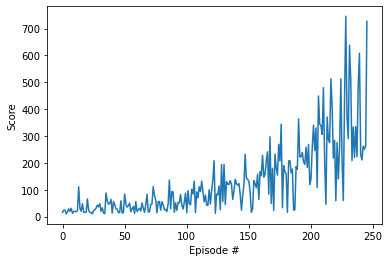

In [5]:
scores = train_agent()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Debuging process

Below a snippet of code responsible for a learning step. As this part of code was challenging, I wrapped it up here for debugging & learning purposes. The only purpose of it is to understand what's going on in the algorithm. 

In [6]:
batch_size = 1

experiences = agent.memory.sample(batch_size, 1)

states, actions, rewards, next_states, dones, weights, idxes = experiences

states = torch.FloatTensor(states).to(device)
actions = torch.LongTensor(actions.reshape(-1, 1)).to(device)
rewards = torch.FloatTensor(rewards.reshape(-1, 1)).to(device)
next_states = torch.FloatTensor(next_states).to(device)
dones = torch.FloatTensor(dones.reshape(-1, 1)).to(device)        
weights = torch.FloatTensor(weights.reshape(-1, 1)).to(device)  


delta_z = float(agent.v_max - agent.v_min) / (agent.atom_size - 1)

with torch.no_grad():
    next_actions = agent.local_network(next_states).argmax(1, keepdim=True)
    next_dist = agent.target_network.dist(next_states)[range(batch_size), next_actions.squeeze(1)]
    target_z = rewards + (1 - dones) * agent.gamma * agent.support
    target_z = target_z.clamp(min=agent.v_min, max=agent.v_max)
    
    b = (target_z - agent.v_min) / delta_z
    lower = b.floor().long()
    upper = b.ceil().long()    
    
    offset = torch.linspace(
        0, 
        (batch_size - 1) * agent.atom_size, 
        batch_size
        )\
        .long().unsqueeze(1)\
        .expand(batch_size, agent.atom_size)\
        .to(device)
    
    proj_dist = torch.zeros(next_dist.size(), device=device)      
    proj_dist.view(-1).index_add_(
        0, 
        (lower + offset).view(-1), 
        (next_dist * (upper.float() - b)).view(-1)
        )
    
dist = agent.local_network.dist(states)
log_p = torch.log(dist[range(batch_size), actions.squeeze(1)])    
elementwise_loss = -(proj_dist * log_p).sum(1)    